In [1]:
# Load python modules
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Resizing, Rescaling
import seaborn as sns
import tensorflow_datasets as tfds
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm  # Perform iterature with progress bar
import numpy as np
import PIL.Image
import PIL
import cv2
import os

In [2]:
#Class labelsb
class_names = ['Glass', 'Metal', 'Paper', 'Textile']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (64, 64)

In [3]:
print('Number of classes:', nb_classes)

Number of classes: 4


In [4]:
resize_layer_32 = tf.keras.Sequential([
    Resizing(32, 32),
])

In [5]:
# Path to Dataset 

# Dataset with 4 classes - 270 images for training and 50 images for testing per class
train_ds_1 = 'C:/Mani/Dataset/dataset1/train_ds'
test_ds_1 = 'C:/Mani/Dataset/dataset1/test_ds'

# Dataset with 4 classes - 450 images for training with data augmentation images and 50 images for testing
train_ds_2 = 'C:/Mani/Dataset/dataset2/train_ds'
test_ds_2 = 'C:/Mani/Dataset/dataset2/test_ds'


# Dataset with 6 classes - 450 images for training with data augmentation images and 50 images for testing
train_ds_3 = 'C:/Mani/Dataset/dataset3/train_ds'
test_ds_3 = 'C:/Mani/Dataset/dataset3/test_ds'


In [6]:
def load_data(train_path, test_path):
    """
        Load the data from local folder
        
    """
    datasets = [train_path, test_path]  
    
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        #Empty Image and Labels list
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [7]:
#Prepare dataset for training and testing
(train_images, train_labels), (test_images, test_labels) = load_data(train_ds_2, test_ds_2)

Loading C:/Mani/Dataset/dataset2/train_ds


100%|███████████████████████████████████████████████████████████████████████████████| 450/450 [00:01<00:00, 226.80it/s]


Loading C:/Mani/Dataset/dataset2/test_ds


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 198.19it/s]


In [8]:
#Check the training and testing image shape
train_images.shape, test_images.shape

((1800, 64, 64, 3), (200, 64, 64, 3))

In [9]:
# Shuffle only the training dataset
np.random.seed(321)
train_images, train_labels = shuffle(train_images, train_labels)
test_images, test_labels = shuffle(test_images, test_labels)

In [10]:
#Check the number of training dataset
print('No of training images:', train_images.shape[0])

No of training images: 1800


In [11]:
#Normalise train and test image dataset from 0,255 to 0,1
train_images = train_images / 255.0 
test_images = test_images / 255.0

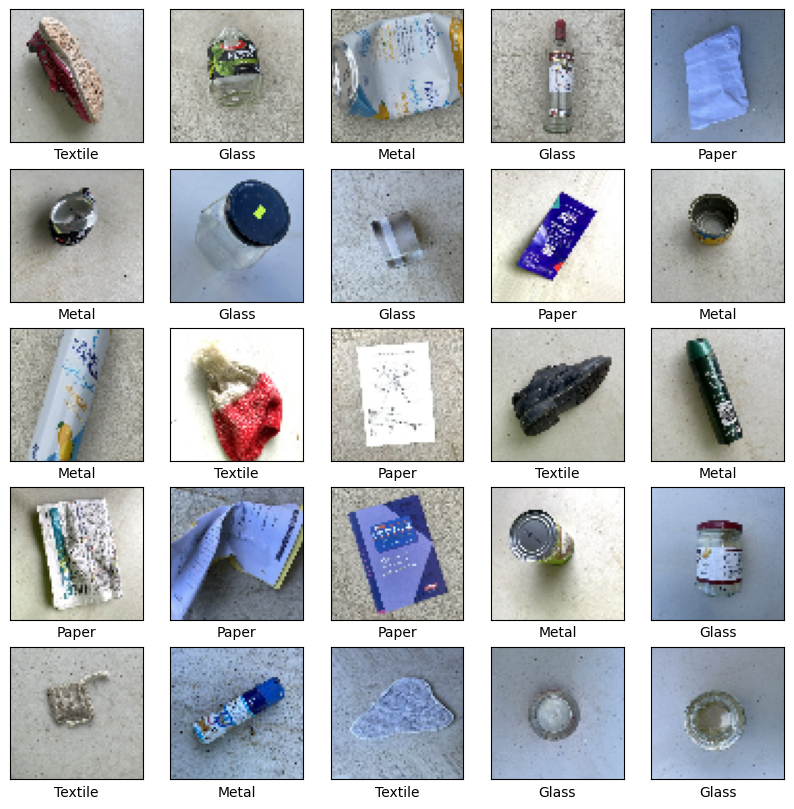

In [12]:
#Display 25 images 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [13]:
#Sequential Model 1
# Experience 3 with Batch Normalisation
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((None,None,3)),
    resize_layer_32,
    
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.05), activation = 'relu'),                                                      
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 544,708 (2.08 MB)

 Trainable params: 544,516 (2.08 MB)

 Non-trainable params: 192 (768.00 B)

In [14]:
#Sequential Model 2 
# With Batch Normalisation

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    
    #Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.01), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.01), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.01), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block 4
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.01), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
       
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(4, activation='softmax')
       
])

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 300,420 (1.15 MB)

 Trainable params: 299,588 (1.14 MB)

 Non-trainable params: 832 (3.25 KB)

In [15]:
#Sequential Model 3 
# Model 3 with batch normalisation

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (5,5), padding='same', kernel_regularizer=regularizers.l2(0.05), activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation ='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    # Block 4
    tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    #Block 5
    tf.keras.layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.05), activation ='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation ='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(4, activation='softmax')      
])

model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 4, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 2, 2, 32)            │              

 Total params: 236,580 (924.14 KB)

 Trainable params: 235,940 (921.64 KB)

 Non-trainable params: 640 (2.50 KB)

In [16]:
# Add callbacks to save the model weight with best accuracy during training

#import ModelCheckpoint package
#from tensorflow.keras.callbacks import ModelCheckpoint
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath1 = 'C:/Mani/ModelCheckpoint/model1.keras'
model_checkpoint_callback1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


checkpoint_filepath2 = 'C:/Mani/ModelCheckpoint/model2.keras'
model_checkpoint_callback2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint_filepath3 = 'C:/Mani/ModelCheckpoint/model3.keras'
model_checkpoint_callback3 = ModelCheckpoint(
    filepath=checkpoint_filepath3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [17]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(0.0015),
                loss = 'sparse_categorical_crossentropy', 
                metrics=['accuracy'])


model_2.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


model_3.compile(optimizer = tf.keras.optimizers.Adam(0.00098),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
               

In [18]:
#Learning rate scheduler for Model 1 and 2

def scheduler1(epoch, lr):
    if epoch <= 30:
        return lr
    else:
        return lr * 0.95
        
    
lr_callback1 = LearningRateScheduler(scheduler1, verbose=1)

In [19]:
#Learning rate scheduler for Model 3

def scheduler2(epoch, lr):
    if epoch <= 45:
        return lr
    else:
        return lr * 0.95
        
    
lr_callback2 = LearningRateScheduler(scheduler2, verbose=1)

In [20]:
# Set number of epochs
epochs = 150
batch_size = 64

## Model fitting with validation split 0.2 or 20%

In [21]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history1 = model_1.fit(train_images, train_labels,
                      batch_size=batch_size, epochs=epochs,
                      validation_split = 0.2, verbose=1,
                      callbacks=[lr_callback1, model_checkpoint_callback1])

# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_1_training_time', end_time - start_time)


Time model start: 2024-11-14 20:40:47.996537

Epoch 1: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 1/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3542 - loss: 18.0542
Epoch 1: val_accuracy improved from -inf to 0.28611, saving model to C:/Mani/ModelCheckpoint/model1.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.3610 - loss: 17.7959 - val_accuracy: 0.2861 - val_loss: 10.5663 - learning_rate: 0.0015

Epoch 2: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 2/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5690 - loss: 9.2638
Epoch 2: val_accuracy improved from 0.28611 to 0.37500, saving model to C:/Mani/ModelCheckpoint/model1.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5703 - loss: 9.1823 - val_accuracy: 0.3750 - val_loss: 6.7590 - learning_rate: 0.0015

Epoch 3: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 3/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/s


Epoch 20: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 20/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8680 - loss: 1.2595
Epoch 20: val_accuracy improved from 0.37500 to 0.45833, saving model to C:/Mani/ModelCheckpoint/model1.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8657 - loss: 1.2631 - val_accuracy: 0.4583 - val_loss: 2.1718 - learning_rate: 0.0015

Epoch 21: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 21/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8723 - loss: 1.2058
Epoch 21: val_accuracy did not improve from 0.45833
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8706 - loss: 1.2086 - val_accuracy: 0.4556 - val_loss: 1.9776 - learning_rate: 0.0015

Epoch 22: LearningRateScheduler setting learning rate to 0.001500000013038516.
Epoch 22/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8667 - loss: 1.2245
Epoch 22: val_accuracy did not improve from 0.45833
23/23


Epoch 39: LearningRateScheduler setting learning rate to 0.0009951305866707117.
Epoch 39/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9321 - loss: 0.8233
Epoch 39: val_accuracy did not improve from 0.78056
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9309 - loss: 0.8250 - val_accuracy: 0.6194 - val_loss: 1.6155 - learning_rate: 9.9513e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0009453740960452705.
Epoch 40/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9383 - loss: 0.7683
Epoch 40: val_accuracy did not improve from 0.78056
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9380 - loss: 0.7692 - val_accuracy: 0.7472 - val_loss: 1.1885 - learning_rate: 9.4537e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0008981053746538237.
Epoch 41/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9434 - loss: 0.7305
Epoch 41: val_accuracy did not improve from 0.78056
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 

22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9917 - loss: 0.3316
Epoch 57: val_accuracy did not improve from 0.85833
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9912 - loss: 0.3320 - val_accuracy: 0.8028 - val_loss: 0.8188 - learning_rate: 3.9528e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0003755161000299267.
Epoch 58/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9790 - loss: 0.3425
Epoch 58: val_accuracy did not improve from 0.85833
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9794 - loss: 0.3425 - val_accuracy: 0.8139 - val_loss: 0.7526 - learning_rate: 3.7552e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.00035674029641086236.
Epoch 59/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9825 - loss: 0.3329
Epoch 59: val_accuracy did not improve from 0.85833
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9823 - loss: 0.3337 - val_accuracy: 0.8139 - val_loss: 0.8560 - learning_rate: 3.5674e-04



Epoch 76/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9947 - loss: 0.2338
Epoch 76: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9947 - loss: 0.2339 - val_accuracy: 0.8444 - val_loss: 0.6071 - learning_rate: 1.4916e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.00014170235735946334.
Epoch 77/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9982 - loss: 0.2274
Epoch 77: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9981 - loss: 0.2275 - val_accuracy: 0.8444 - val_loss: 0.5647 - learning_rate: 1.4170e-04

Epoch 78: LearningRateScheduler setting learning rate to 0.0001346172415651381.
Epoch 78/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9932 - loss: 0.2367
Epoch 78: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9932 - loss: 0.2362 - val_accuracy: 0.8500 - val_loss: 0.5858 - learning_rate:

Epoch 95/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9962 - loss: 0.1997
Epoch 95: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9962 - loss: 0.1996 - val_accuracy: 0.8472 - val_loss: 0.5456 - learning_rate: 5.6286e-05

Epoch 96: LearningRateScheduler setting learning rate to 5.3471887076739216e-05.
Epoch 96/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9973 - loss: 0.1982
Epoch 96: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9972 - loss: 0.1981 - val_accuracy: 0.8528 - val_loss: 0.5430 - learning_rate: 5.3472e-05

Epoch 97: LearningRateScheduler setting learning rate to 5.0798291340470314e-05.
Epoch 97/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9991 - loss: 0.1946
Epoch 97: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9990 - loss: 0.1949 - val_accuracy: 0.8556 - val_loss: 0.5439 - learning_rate

Epoch 114/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9995 - loss: 0.1835
Epoch 114: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9994 - loss: 0.1836 - val_accuracy: 0.8389 - val_loss: 0.5466 - learning_rate: 2.1240e-05

Epoch 115: LearningRateScheduler setting learning rate to 2.017781080212444e-05.
Epoch 115/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9994 - loss: 0.1797
Epoch 115: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9993 - loss: 0.1800 - val_accuracy: 0.8528 - val_loss: 0.5354 - learning_rate: 2.0178e-05

Epoch 116: LearningRateScheduler setting learning rate to 1.9168920607626203e-05.
Epoch 116/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9960 - loss: 0.1853
Epoch 116: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9961 - loss: 0.1854 - val_accuracy: 0.8472 - val_loss: 0.5293 - learni

Epoch 133/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9940 - loss: 0.1852
Epoch 133: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9942 - loss: 0.1850 - val_accuracy: 0.8556 - val_loss: 0.5253 - learning_rate: 8.0149e-06

Epoch 134: LearningRateScheduler setting learning rate to 7.6141699082654665e-06.
Epoch 134/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9966 - loss: 0.1847
Epoch 134: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9965 - loss: 0.1847 - val_accuracy: 0.8500 - val_loss: 0.5255 - learning_rate: 7.6142e-06

Epoch 135: LearningRateScheduler setting learning rate to 7.233461542455188e-06.
Epoch 135/150
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9996 - loss: 0.1800
Epoch 135: val_accuracy did not improve from 0.87222
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9996 - loss: 0.1801 - val_accuracy: 0.8389 - val_loss: 0.5279 - learni

In [22]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)


history2 = model_2.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback1, model_checkpoint_callback2])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_2_training_time', end_time - start_time)


Time model start: 2024-11-14 20:44:23.519245

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.4060 - loss: 6.0726
Epoch 1: val_accuracy improved from -inf to 0.24444, saving model to C:/Mani/ModelCheckpoint/model2.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 287ms/step - accuracy: 0.4087 - loss: 6.0607 - val_accuracy: 0.2444 - val_loss: 5.9514 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6107 - loss: 5.2456
Epoch 2: val_accuracy did not improve from 0.24444
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.6112 - loss: 5.2429 - val_accuracy: 0.2444 - val_loss: 7.2650 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.7215 - loss: 4.7289
Epoch 3: val_a

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.9302 - loss: 1.4041 - val_accuracy: 0.2806 - val_loss: 6.0025 - learning_rate: 0.0010

Epoch 20: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 20/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9439 - loss: 1.2990
Epoch 20: val_accuracy improved from 0.28056 to 0.30556, saving model to C:/Mani/ModelCheckpoint/model2.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.9436 - loss: 1.2991 - val_accuracy: 0.3056 - val_loss: 4.7709 - learning_rate: 0.0010

Epoch 21: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 21/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9505 - loss: 1.2438
Epoch 21: val_accuracy improved from 0.30556 to 0.37500, saving model to C:/Mani/ModelCheckpoint/model2.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.9501 - loss: 1.2438 - val_accuracy: 0.3750 - val_loss: 4.5814 - learning_rate: 0.0010

Epoch 22: Learning

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.9784 - loss: 0.6428 - val_accuracy: 0.7472 - val_loss: 1.3026 - learning_rate: 7.3509e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0006983372120885178.
Epoch 38/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9794 - loss: 0.6158
Epoch 38: val_accuracy did not improve from 0.80278
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.9795 - loss: 0.6154 - val_accuracy: 0.7306 - val_loss: 1.2962 - learning_rate: 6.9834e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0006634203542489559.
Epoch 39/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9868 - loss: 0.5731
Epoch 39: val_accuracy did not improve from 0.80278
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.9867 - loss: 0.5729 - val_accuracy: 0.8028 - val_loss: 1.0107 - learning_rate: 6.6342e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0006302493420662358.
Epoch 40/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s


Epoch 56: LearningRateScheduler setting learning rate to 0.00027738953212974593.
Epoch 56/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9964 - loss: 0.3231
Epoch 56: val_accuracy did not improve from 0.88333
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - accuracy: 0.9964 - loss: 0.3230 - val_accuracy: 0.8583 - val_loss: 0.6630 - learning_rate: 2.7739e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.0002635200624354184.
Epoch 57/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9973 - loss: 0.3117
Epoch 57: val_accuracy did not improve from 0.88333
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.9972 - loss: 0.3117 - val_accuracy: 0.8694 - val_loss: 0.6122 - learning_rate: 2.6352e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0002503440482541919.
Epoch 58/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9973 - loss: 0.3058
Epoch 58: val_accuracy did not improve from 0.88333
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - acc


Epoch 75: LearningRateScheduler setting learning rate to 0.00010467393149156123.
Epoch 75/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 1.0000 - loss: 0.2162
Epoch 75: val_accuracy did not improve from 0.90278
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 1.0000 - loss: 0.2162 - val_accuracy: 0.8667 - val_loss: 0.5722 - learning_rate: 1.0467e-04

Epoch 76: LearningRateScheduler setting learning rate to 9.944023768184706e-05.
Epoch 76/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9999 - loss: 0.2145
Epoch 76: val_accuracy did not improve from 0.90278
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.9999 - loss: 0.2145 - val_accuracy: 0.8750 - val_loss: 0.5530 - learning_rate: 9.9440e-05

Epoch 77: LearningRateScheduler setting learning rate to 9.446822441532275e-05.
Epoch 77/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 1.0000 - loss: 0.2131
Epoch 77: val_accuracy did not improve from 0.90278
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - acc


Epoch 94: LearningRateScheduler setting learning rate to 3.949908405047608e-05.
Epoch 94/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 1.0000 - loss: 0.1825
Epoch 94: val_accuracy did not improve from 0.90556
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 1.0000 - loss: 0.1826 - val_accuracy: 0.8972 - val_loss: 0.4449 - learning_rate: 3.9499e-05

Epoch 95: LearningRateScheduler setting learning rate to 3.752413140318822e-05.
Epoch 95/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 1.0000 - loss: 0.1809
Epoch 95: val_accuracy did not improve from 0.90556
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 1.0000 - loss: 0.1809 - val_accuracy: 0.8944 - val_loss: 0.4361 - learning_rate: 3.7524e-05

Epoch 96: LearningRateScheduler setting learning rate to 3.564792586985277e-05.
Epoch 96/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 1.0000 - loss: 0.1797
Epoch 96: val_accuracy improved from 0.90556 to 0.90833, saving model to C:/Mani/ModelCheckpoint/mo

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 1.0000 - loss: 0.1682 - val_accuracy: 0.9028 - val_loss: 0.4268 - learning_rate: 1.5690e-05

Epoch 113: LearningRateScheduler setting learning rate to 1.490512377131381e-05.
Epoch 113/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 1.0000 - loss: 0.1681
Epoch 113: val_accuracy did not improve from 0.91111
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 1.0000 - loss: 0.1681 - val_accuracy: 0.9028 - val_loss: 0.4291 - learning_rate: 1.4905e-05

Epoch 114: LearningRateScheduler setting learning rate to 1.4159867669150115e-05.
Epoch 114/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 1.0000 - loss: 0.1674
Epoch 114: val_accuracy did not improve from 0.91111
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 1.0000 - loss: 0.1674 - val_accuracy: 0.9056 - val_loss: 0.4324 - learning_rate: 1.4160e-05

Epoch 115: LearningRateScheduler setting learning rate to 1.3451874156089615e-05.
Epoch 115/150
23/23 ━━━━━━━━━━━━━

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 1.0000 - loss: 0.1633
Epoch 131: val_accuracy did not improve from 0.91111
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 1.0000 - loss: 0.1633 - val_accuracy: 0.9056 - val_loss: 0.4239 - learning_rate: 5.9205e-06

Epoch 132: LearningRateScheduler setting learning rate to 5.624501704915019e-06.
Epoch 132/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 1.0000 - loss: 0.1613
Epoch 132: val_accuracy did not improve from 0.91111
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 1.0000 - loss: 0.1613 - val_accuracy: 0.9000 - val_loss: 0.4238 - learning_rate: 5.6245e-06

Epoch 133: LearningRateScheduler setting learning rate to 5.343276598068769e-06.
Epoch 133/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 1.0000 - loss: 0.1615
Epoch 133: val_accuracy did not improve from 0.91111
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 1.0000 - loss: 0.1615 - val_accuracy: 0.9028 - val_loss: 0.4235 - learning_rate: 


Epoch 150: LearningRateScheduler setting learning rate to 2.2341329326991397e-06.
Epoch 150/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 1.0000 - loss: 0.1604
Epoch 150: val_accuracy did not improve from 0.91111
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step - accuracy: 1.0000 - loss: 0.1604 - val_accuracy: 0.9028 - val_loss: 0.4166 - learning_rate: 2.2341e-06
Time model end: 2024-11-14 21:00:09.422472
Model_2_training_time 0:15:45.903227


In [23]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history3 = model_3.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[lr_callback2, model_checkpoint_callback3])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_3_training_time', end_time - start_time )

Time model start: 2024-11-14 21:00:09.430950

Epoch 1: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 1/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.3312 - loss: 14.4450
Epoch 1: val_accuracy improved from -inf to 0.24444, saving model to C:/Mani/ModelCheckpoint/model3.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 338ms/step - accuracy: 0.3338 - loss: 14.4200 - val_accuracy: 0.2444 - val_loss: 12.6692 - learning_rate: 9.8000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 2/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5243 - loss: 11.8802
Epoch 2: val_accuracy did not improve from 0.24444
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step - accuracy: 0.5240 - loss: 11.8606 - val_accuracy: 0.2444 - val_loss: 10.6914 - learning_rate: 9.8000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 3/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.5575 - loss: 9.6622


Epoch 19/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8232 - loss: 1.1774
Epoch 19: val_accuracy did not improve from 0.28611
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 315ms/step - accuracy: 0.8233 - loss: 1.1772 - val_accuracy: 0.2750 - val_loss: 4.6146 - learning_rate: 9.8000e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 20/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.8094 - loss: 1.1823
Epoch 20: val_accuracy improved from 0.28611 to 0.32500, saving model to C:/Mani/ModelCheckpoint/model3.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 321ms/step - accuracy: 0.8100 - loss: 1.1810 - val_accuracy: 0.3250 - val_loss: 3.1458 - learning_rate: 9.8000e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 21/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.8442 - loss: 1.0704
Epoch 21: val_accuracy improved from 0.32500 to 0.35278, saving model to C:/Mani/ModelCheckpoint/model3.keras
23/23 ━━━━━━

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8794 - loss: 0.9560
Epoch 37: val_accuracy did not improve from 0.70000
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 319ms/step - accuracy: 0.8785 - loss: 0.9579 - val_accuracy: 0.5000 - val_loss: 1.8769 - learning_rate: 9.8000e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 38/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.8905 - loss: 0.9261
Epoch 38: val_accuracy did not improve from 0.70000
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 314ms/step - accuracy: 0.8903 - loss: 0.9270 - val_accuracy: 0.5167 - val_loss: 2.2323 - learning_rate: 9.8000e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0009800000116229057.
Epoch 39/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8855 - loss: 0.9259
Epoch 39: val_accuracy did not improve from 0.70000
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.8856 - loss: 0.9258 - val_accuracy: 0.6472 - val_loss: 1.4093 - learning_rate: 9.8000e


Epoch 56: LearningRateScheduler setting learning rate to 0.0005867622356163337.
Epoch 56/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9358 - loss: 0.6450
Epoch 56: val_accuracy did not improve from 0.75556
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.9357 - loss: 0.6457 - val_accuracy: 0.6250 - val_loss: 1.6051 - learning_rate: 5.8676e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.000557424098951742.
Epoch 57/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9298 - loss: 0.6730
Epoch 57: val_accuracy improved from 0.75556 to 0.75833, saving model to C:/Mani/ModelCheckpoint/model3.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 320ms/step - accuracy: 0.9291 - loss: 0.6746 - val_accuracy: 0.7583 - val_loss: 1.3007 - learning_rate: 5.5742e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0005295528884744271.
Epoch 58/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9421 - loss: 0.6544
Epoch 58: val_accuracy did not improve fro

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9856 - loss: 0.3569
Epoch 74: val_accuracy did not improve from 0.82500
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.9855 - loss: 0.3571 - val_accuracy: 0.7139 - val_loss: 1.0704 - learning_rate: 2.3307e-04

Epoch 75: LearningRateScheduler setting learning rate to 0.00022141677036415785.
Epoch 75/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9777 - loss: 0.3695
Epoch 75: val_accuracy improved from 0.82500 to 0.82778, saving model to C:/Mani/ModelCheckpoint/model3.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 319ms/step - accuracy: 0.9779 - loss: 0.3690 - val_accuracy: 0.8278 - val_loss: 0.9078 - learning_rate: 2.2142e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.00021034593737567775.
Epoch 76/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9844 - loss: 0.3352
Epoch 76: val_accuracy did not improve from 0.82778
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 313ms/step - accuracy: 0.9844 - loss: 0.3351 - val_

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9938 - loss: 0.2310
Epoch 92: val_accuracy did not improve from 0.89722
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 314ms/step - accuracy: 0.9938 - loss: 0.2311 - val_accuracy: 0.8583 - val_loss: 0.6281 - learning_rate: 9.2579e-05

Epoch 93: LearningRateScheduler setting learning rate to 8.794991263130214e-05.
Epoch 93/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9939 - loss: 0.2352
Epoch 93: val_accuracy did not improve from 0.89722
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 313ms/step - accuracy: 0.9939 - loss: 0.2351 - val_accuracy: 0.8472 - val_loss: 0.7431 - learning_rate: 8.7950e-05

Epoch 94: LearningRateScheduler setting learning rate to 8.355241734534501e-05.
Epoch 94/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9928 - loss: 0.2251
Epoch 94: val_accuracy did not improve from 0.89722
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 314ms/step - accuracy: 0.9926 - loss: 0.2253 - val_accuracy: 0.8917 - val_loss: 0.5630 - learning_rate: 8.3552e


Epoch 111: LearningRateScheduler setting learning rate to 3.49349676980637e-05.
Epoch 111/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9998 - loss: 0.1736
Epoch 111: val_accuracy did not improve from 0.91111
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.9997 - loss: 0.1737 - val_accuracy: 0.8972 - val_loss: 0.5340 - learning_rate: 3.4935e-05

Epoch 112: LearningRateScheduler setting learning rate to 3.318822000437649e-05.
Epoch 112/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9992 - loss: 0.1750
Epoch 112: val_accuracy did not improve from 0.91111
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 314ms/step - accuracy: 0.9992 - loss: 0.1749 - val_accuracy: 0.9000 - val_loss: 0.5245 - learning_rate: 3.3188e-05

Epoch 113: LearningRateScheduler setting learning rate to 3.1528807448921724e-05.
Epoch 113/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9981 - loss: 0.1745
Epoch 113: val_accuracy did not improve from 0.91111
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/st


Epoch 130: LearningRateScheduler setting learning rate to 1.3182836482883431e-05.
Epoch 130/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 1.0000 - loss: 0.1564
Epoch 130: val_accuracy did not improve from 0.91111
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 1.0000 - loss: 0.1565 - val_accuracy: 0.8861 - val_loss: 0.5549 - learning_rate: 1.3183e-05

Epoch 131: LearningRateScheduler setting learning rate to 1.2523694658739258e-05.
Epoch 131/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9989 - loss: 0.1565
Epoch 131: val_accuracy did not improve from 0.91111
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 313ms/step - accuracy: 0.9989 - loss: 0.1565 - val_accuracy: 0.8833 - val_loss: 0.5644 - learning_rate: 1.2524e-05

Epoch 132: LearningRateScheduler setting learning rate to 1.1897510012204293e-05.
Epoch 132/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9997 - loss: 0.1567
Epoch 132: val_accuracy did not improve from 0.91111
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 315ms


Epoch 149: LearningRateScheduler setting learning rate to 4.974591502104886e-06.
Epoch 149/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9995 - loss: 0.1505
Epoch 149: val_accuracy did not improve from 0.91111
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 313ms/step - accuracy: 0.9995 - loss: 0.1505 - val_accuracy: 0.8972 - val_loss: 0.5237 - learning_rate: 4.9746e-06

Epoch 150: LearningRateScheduler setting learning rate to 4.725861754195648e-06.
Epoch 150/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 1.0000 - loss: 0.1505
Epoch 150: val_accuracy did not improve from 0.91111
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 313ms/step - accuracy: 1.0000 - loss: 0.1505 - val_accuracy: 0.8972 - val_loss: 0.5195 - learning_rate: 4.7259e-06
Time model end: 2024-11-14 21:18:37.355615
Model_3_training_time 0:18:27.924665


## Plot the loss and accuracy against epochs during training and validation

Text(0.5, 1.0, 'Model 1 Accuracy (Exp:5.1)')

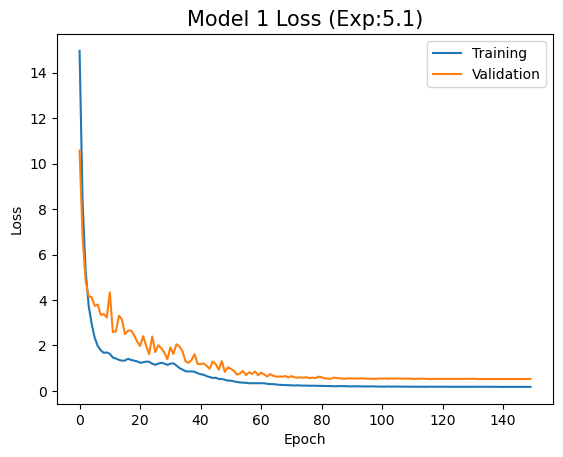

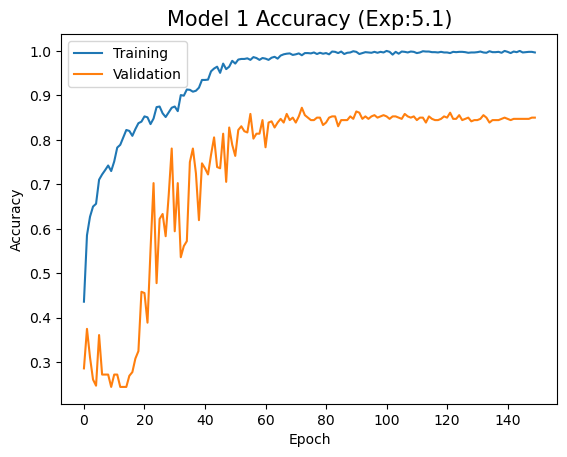

In [24]:

#Plot the training and validation loss
plt.figure()
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1 Loss (Exp:5.1)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 1 Accuracy (Exp:5.1)', fontsize = 15)


Text(0.5, 1.0, 'Model 2 Accuracy (Exp:5.1)')

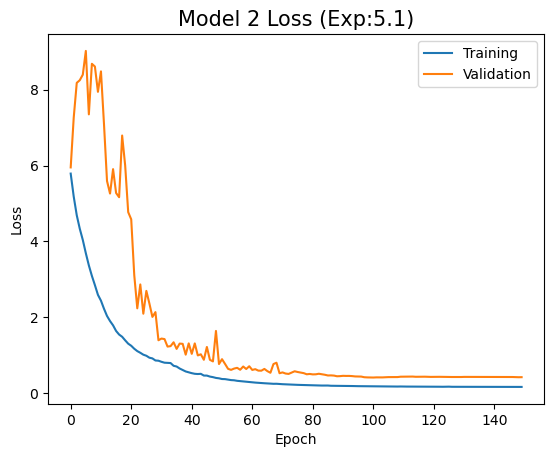

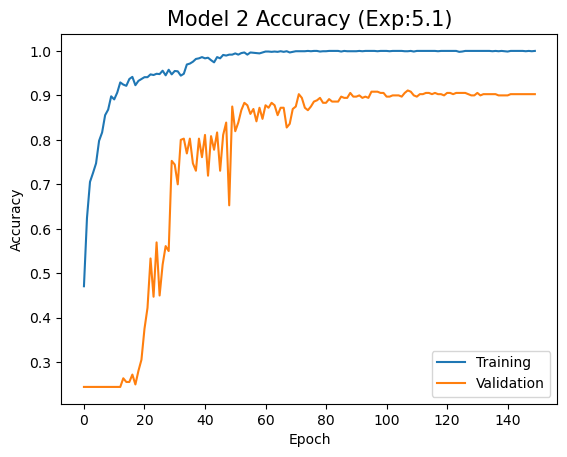

In [25]:
#Plot the training and validation loss
plt.figure()
plt.plot(history2.history['loss'], label='Training')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 Loss (Exp:5.1)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history2.history['accuracy'], label='Training')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 2 Accuracy (Exp:5.1)', fontsize = 15)

Text(0.5, 1.0, 'Model 3 Accuracy (Exp:5.1)')

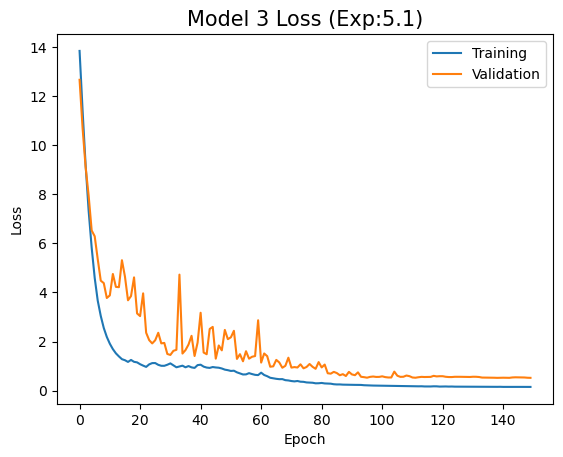

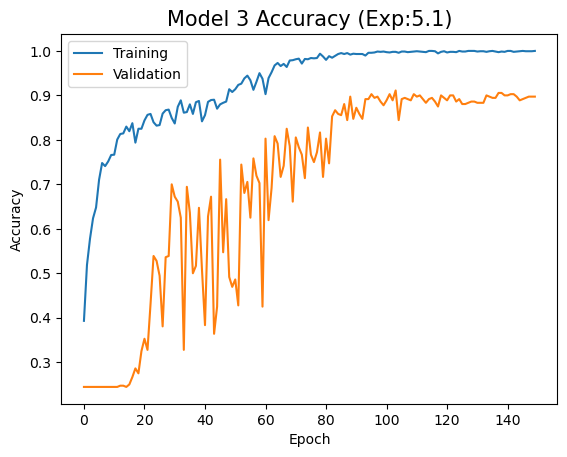

In [26]:
#Plot the training and validation loss
plt.figure()
plt.plot(history3.history['loss'], label='Training')
plt.plot(history3.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 3 Loss (Exp:5.1)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history3.history['accuracy'], label='Training')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 3 Accuracy (Exp:5.1)', fontsize = 15)

## Evaluate the model for test images

In [27]:
# Evaluate the test result for model 1, 2, 3
#model_1.load_weights(checkpoint_filepath1)
Test_result1 = model_1.evaluate(test_images, test_labels, batch_size = 64)

#model_2.load_weights(checkpoint_filepath2)
Test_result2 = model_2.evaluate(test_images, test_labels, batch_size = 64)

#model_3.load_weights(checkpoint_filepath3)
Test_result3 = model_3.evaluate(test_images, test_labels, batch_size = 64)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9292 - loss: 0.3579
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9415 - loss: 0.3251
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9338 - loss: 0.3326


## Confusion matrix for model 1 to 3

In [28]:
predictions1 = model_1.predict(test_images)     # Vector of probabilities
pred_label1 = np.argmax(predictions1, axis = 1) # We take the highest probability


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


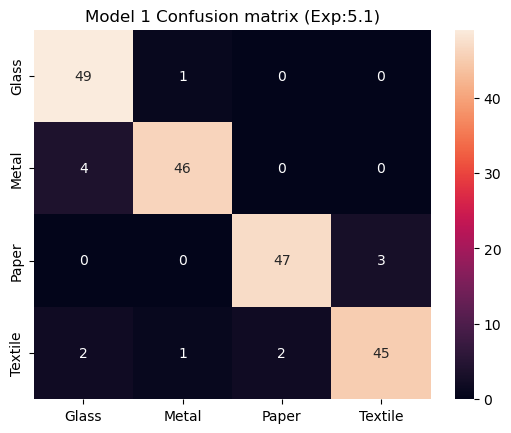

In [29]:
CM1 = confusion_matrix(test_labels, pred_label1)
ax = plt.axes()
sns.heatmap(CM1, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 1 Confusion matrix (Exp:5.1)')
plt.show()

In [30]:
#Obtain the model's prediction for the test_images
predictions2 = model_2.predict(test_images)
pred_label2 = np.argmax(predictions2, axis = 1)



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


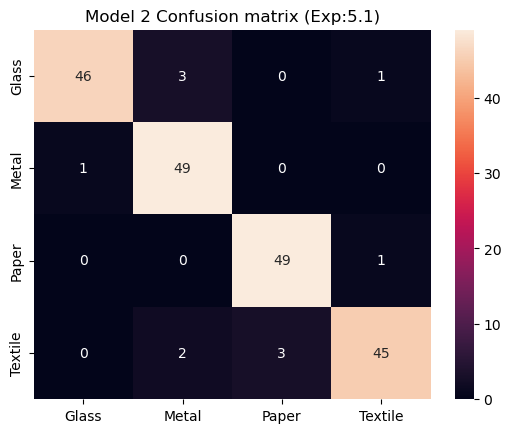

In [31]:
CM2 = confusion_matrix(test_labels, pred_label2)
ax = plt.axes()
sns.heatmap(CM2, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 2 Confusion matrix (Exp:5.1)')
plt.show()

In [32]:
#Obtain the model's prediction for the test_images
predictions3 = model_3.predict(test_images)
pred_label3 = np.argmax(predictions3, axis = 1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


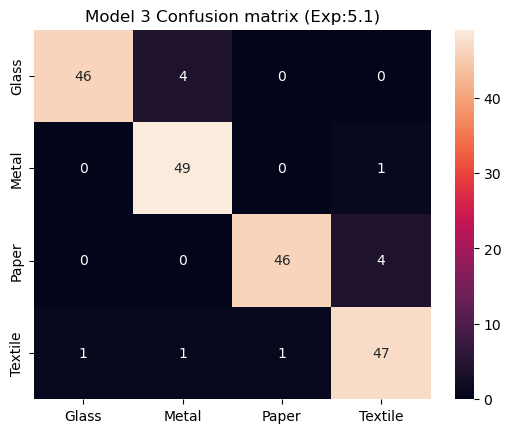

In [33]:
CM3 = confusion_matrix(test_labels, pred_label3)
ax = plt.axes()
sns.heatmap(CM3, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model 3 Confusion matrix (Exp:5.1)')
plt.show()

## Display 25 images for each model with actual and predicted label

25 random image with actual and predicted label for Model 1


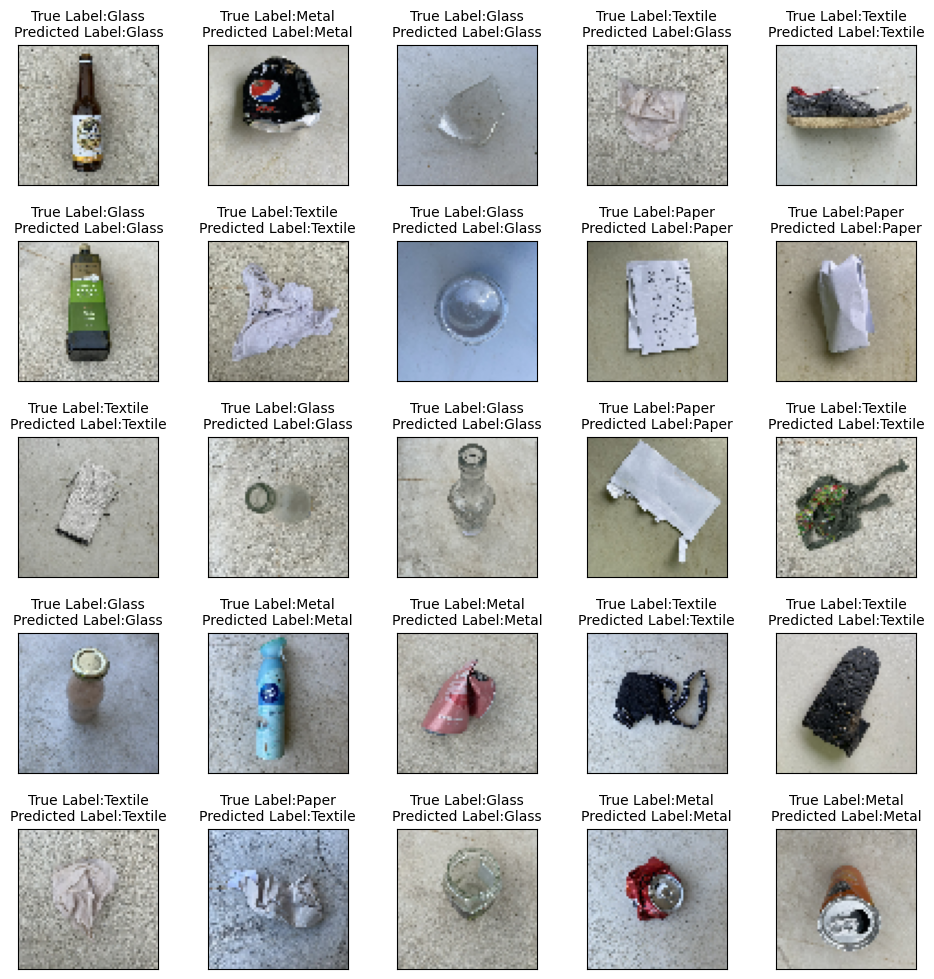

In [34]:
#Display actual and predicted labels for 25 images model 3
print('25 random image with actual and predicted label for Model 1')
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.1)

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(test_images[i])
    plt.title("True Label:" + class_names[test_labels[i]] +"\n"+"Predicted Label:"
              + class_names[pred_label1[i]], fontsize = 10)
    
    
    #plt.show()

25 random image with actual and predicted label for Model 2


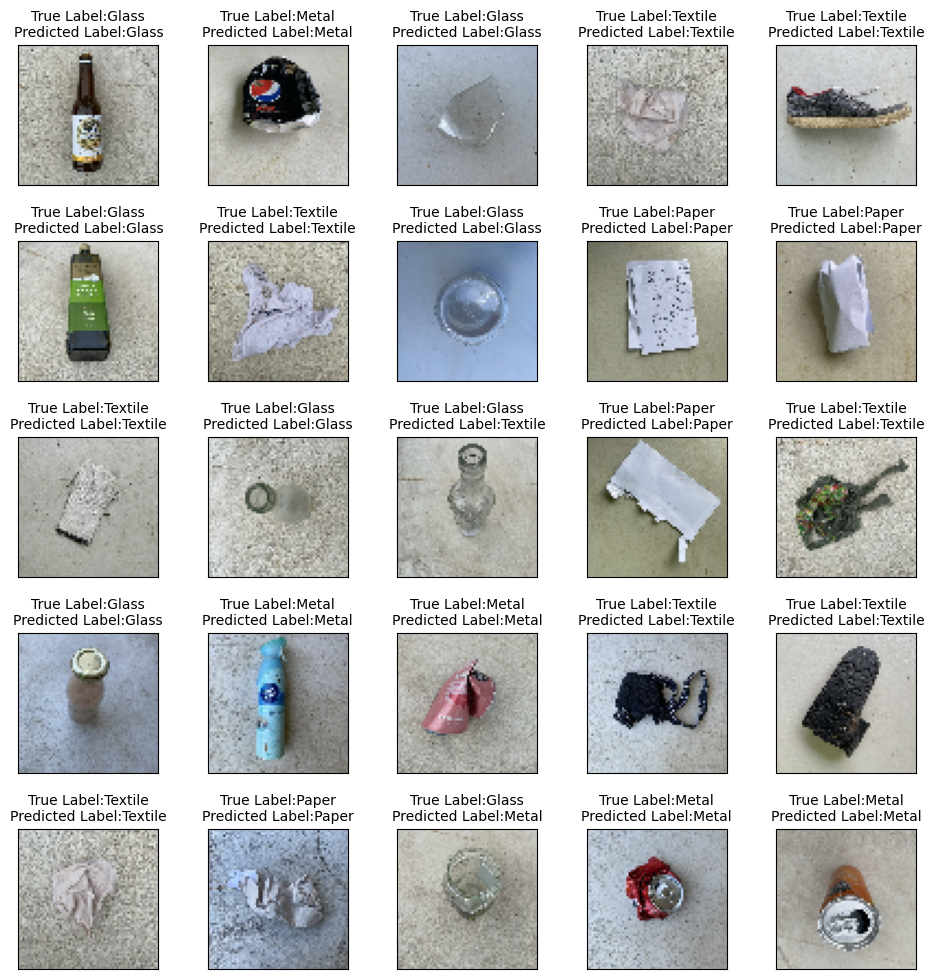

In [35]:
#Display actual and predicted labels for 25 images 
print('25 random image with actual and predicted label for Model 2')
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.1)

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(test_images[i])
    plt.title("True Label:" + class_names[test_labels[i]] +"\n"+"Predicted Label:"
              + class_names[pred_label2[i]], fontsize = 10)
    

25 random image with actual and predicted label for Model 3


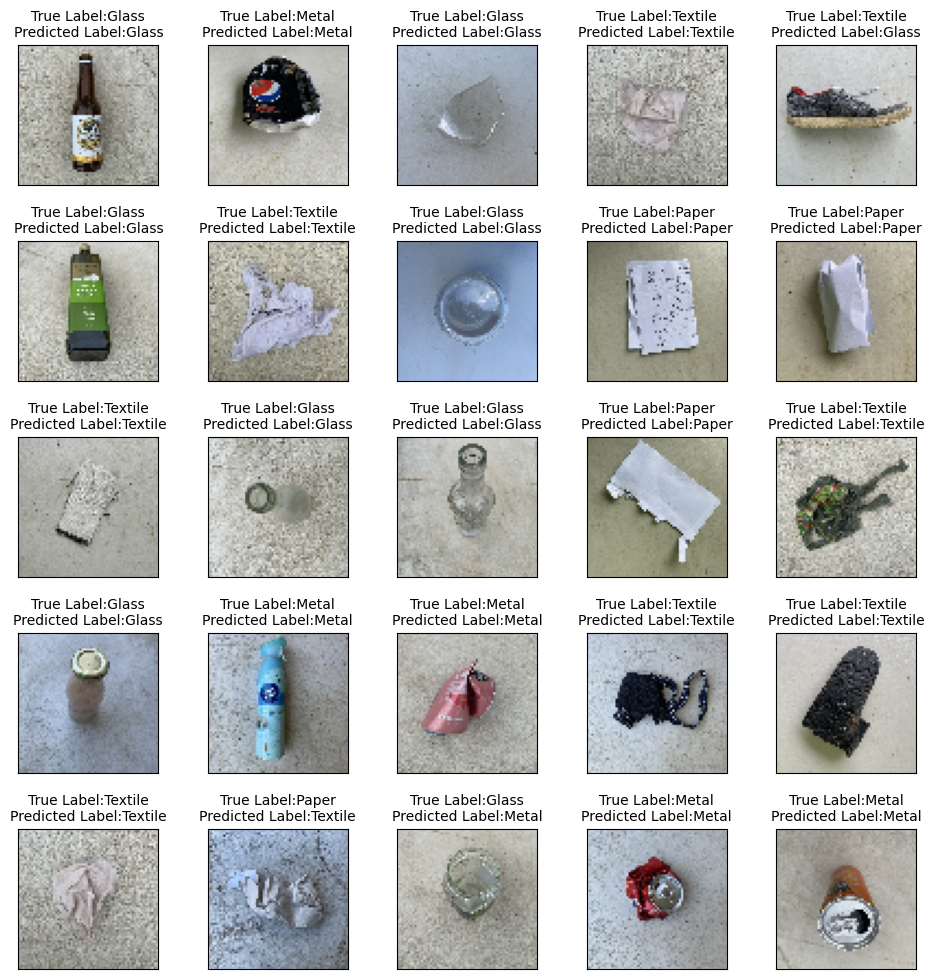

In [36]:
#Display actual and predicted labels for 25 images 
print('25 random image with actual and predicted label for Model 3')
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.1)

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(test_images[i])
    plt.title("True Label:" + class_names[test_labels[i]] +"\n"+"Predicted Label:"
              + class_names[pred_label3[i]], fontsize = 10)
    

## Display the misclassified Image

In [37]:
def display_mislabel_images(class_names, images, labels):
    """
        Display mislabel images from the images array with its corresponding labels
    """
  
    fig = plt.figure(figsize=(15,15))
    #fig.suptitle("mislabeled images", fontsize=16)
    for i in range(8):
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]], fontsize = 15) 
    plt.show()

In [38]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print all the mislabeled images by the classifier
    """
    correct_label = (test_labels == pred_labels)
    mislabeled_indices = np.where(correct_label == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    #actual_label = test_labels[mislabeled_indices]

      
    display_mislabel_images(class_names,  mislabeled_images, mislabeled_labels)

Mislabel image for model 1


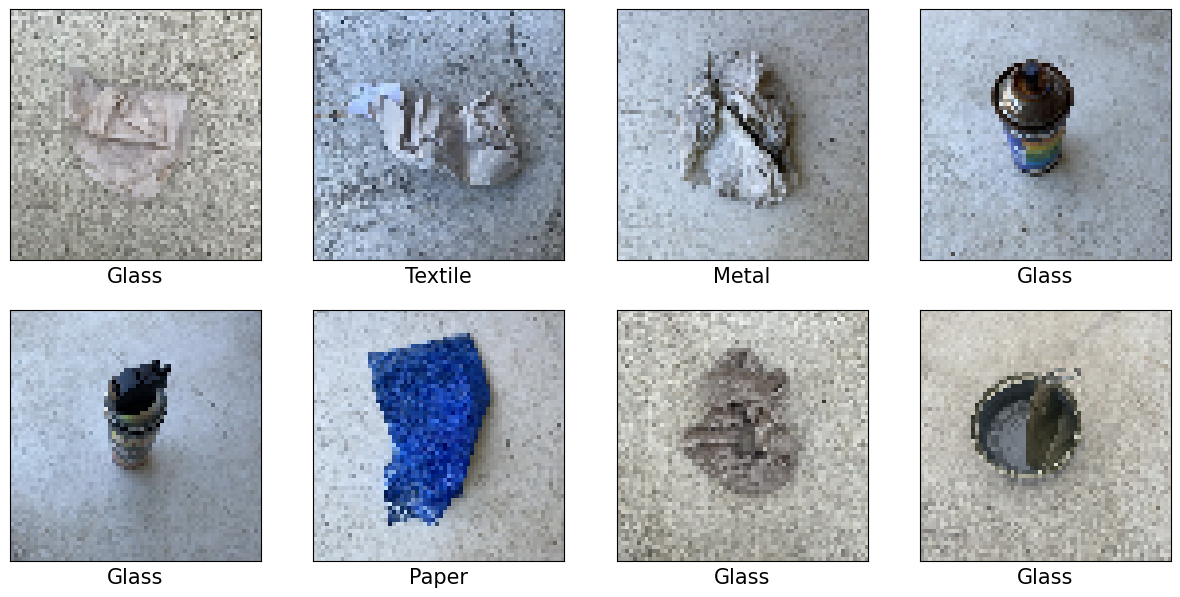

In [39]:
print('Mislabel image for model 1')
print_mislabeled_images(class_names, test_images, test_labels, pred_label1)

Mislabel image for model 2


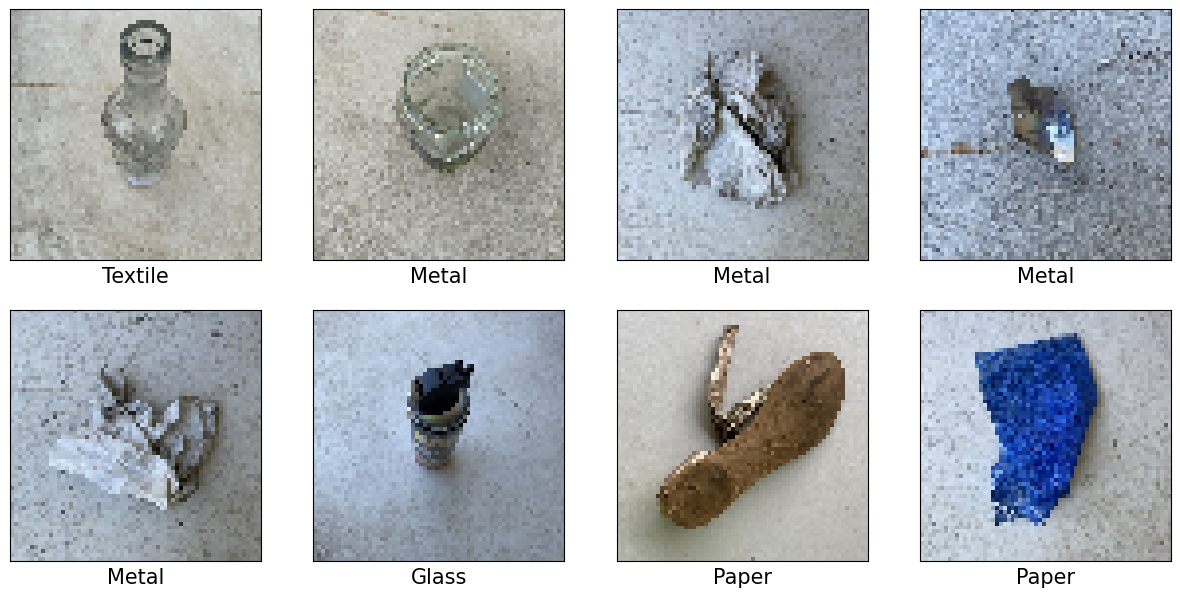

In [40]:
print('Mislabel image for model 2')
print_mislabeled_images(class_names, test_images, test_labels, pred_label2)

Mislabel image for model 3


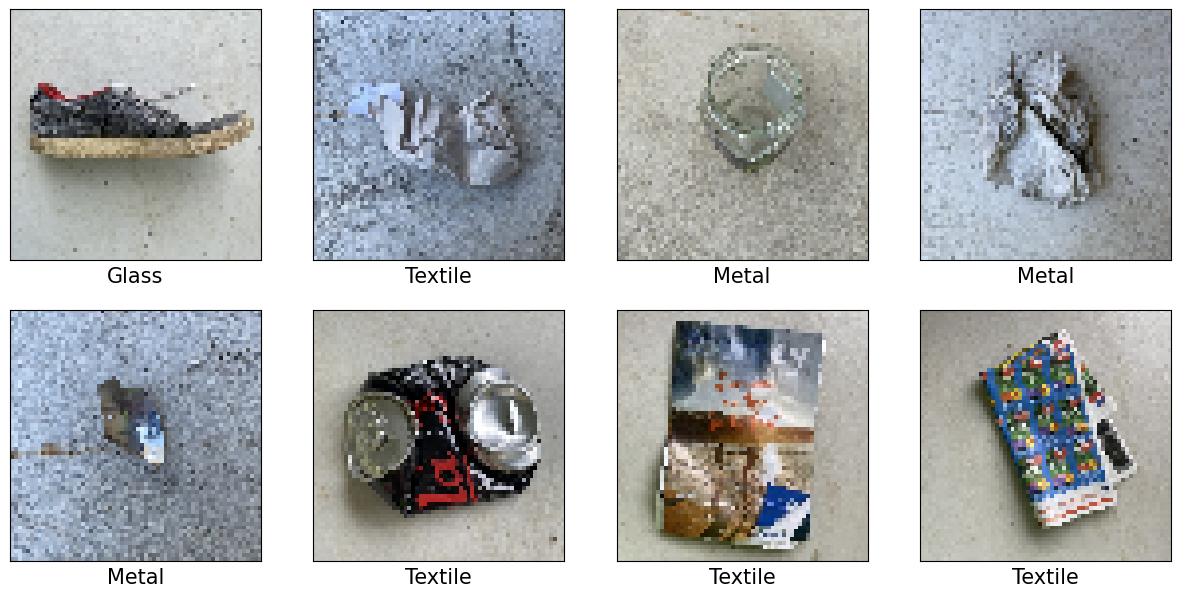

In [41]:
print('Mislabel image for model 3')
print_mislabeled_images(class_names, test_images, test_labels, pred_label3)

## Predict Single Image

Predict start: 2024-11-14 21:18:47.374852


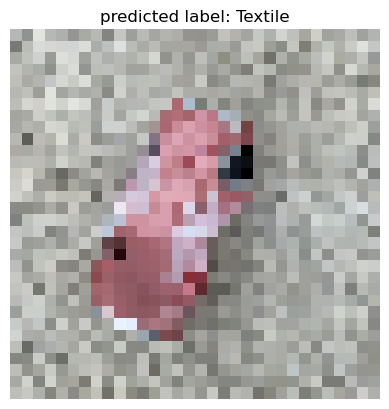

Predict end: 2024-11-14 21:18:47.502136
Prediction time: 0:00:00.127284


In [42]:
# Prediction time for model 1
start_time = datetime.now()
print('Predict start:', start_time)

IMAGE_SIZE = (32, 32)
test_image1 = cv2.imread("C:/test_ds/Metal/Metal_42.jpg")
test_image1 = cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB)
test_image1 = cv2.resize(test_image1, IMAGE_SIZE) 
image1 = tf.constant(test_image1, dtype = tf.float32)
image1 = tf.expand_dims(image1 ,axis = 0)
plt.title('predicted label: ' + class_names[np.argmax(model_1(image1))])
plt.imshow(test_image1)
plt.grid(False)
plt.axis('off')
plt.show()

end_time = datetime.now()
print('Predict end:', end_time)
print('Prediction time:', end_time - start_time)

Predict start: 2024-11-14 21:18:47.511398


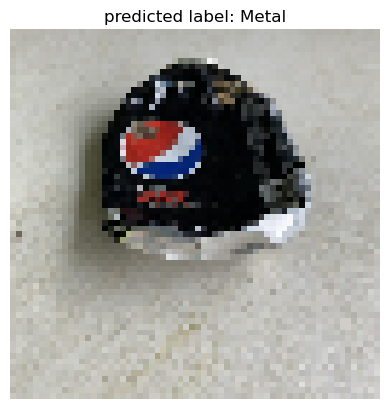

Predict end: 2024-11-14 21:18:47.649737
Prediction time: 0:00:00.138339


In [43]:
# Prediction time for model 2
start_time = datetime.now()
print('Predict start:', start_time)

IMAGE_SIZE = (64, 64)
test_image2 = cv2.imread("C:/test_ds/Metal/Metal_24.jpg")
test_image2 = cv2.cvtColor(test_image2, cv2.COLOR_BGR2RGB)
test_image2 = cv2.resize(test_image2, IMAGE_SIZE) 
image2 = tf.constant(test_image2, dtype = tf.float32)
image2 = tf.expand_dims(image2 ,axis = 0)
plt.title('predicted label: ' + class_names[np.argmax(model_2(image2))])
plt.imshow(test_image2)
plt.grid(False)
plt.axis('off')
plt.show()

end_time = datetime.now()
print('Predict end:', end_time)
print('Prediction time:', end_time - start_time)

Predict start: 2024-11-14 21:18:47.659080


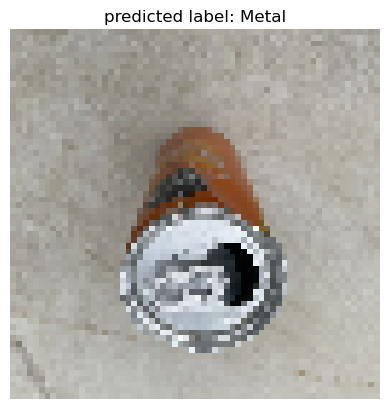

Predict end: 2024-11-14 21:18:47.803115
Prediction time: 0:00:00.144035


In [44]:
# Prediction time for model 3
start_time = datetime.now()
print('Predict start:', start_time)

IMAGE_SIZE = (64, 64)
test_image3 = cv2.imread("C:/test_ds/Metal/Metal_94.jpg")
test_image3 = cv2.cvtColor(test_image3, cv2.COLOR_BGR2RGB)
test_image3 = cv2.resize(test_image3, IMAGE_SIZE) 
image3 = tf.constant(test_image3, dtype = tf.float32)
image3 = tf.expand_dims(image3, axis = 0)
plt.title('predicted label: ' + class_names[np.argmax(model_3(image3))])
plt.imshow(test_image3)
plt.grid(False)
plt.axis('off')
plt.show()

end_time = datetime.now()
print('Predict end:', end_time)
print('Prediction time:', end_time - start_time)